# Imports

In [1]:
# prerequisites
%matplotlib inline
import torch
from torch.func import jacrev,jacfwd
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import math
import numpy as np
from tqdm.notebook import tqdm
import json
import os

## Hyperparameters

In [2]:
set_name = "Swissroll"
#set_name = "Synthetic"
#set_name = "MNIST"

experiment_name = f"{set_name}_torus_AE"
experiment_number = 0
violent_saving = True # if False it will not save plots
Path_experiments = "../experiments/"
Path_pictures = f"../experiments/{experiment_name}/experiment{experiment_number}"
if violent_saving == True:
    if os.path.exists(Path_pictures) == False:
        if os.path.exists(f"../experiments/{experiment_name}/") == False:
            os.mkdir(f"../experiments/{experiment_name}/")
        os.mkdir(Path_pictures) # needs to be commented once the folder for plots is created
Path_weights = "../nn_weights/"

d = 2         # latent space dimension
weights_loaded = False
weights_saved = True

In [3]:
mse_w = 1e1 # 1e4
unif_w = 0 # 4e1 for mnist
compute_curvature = False
if compute_curvature == True:
    curv_w = 1e1
else:
    curv_w = 0.
OOD_regime = False

### Define an optimizer (both for the encoder and the decoder!)
lr         = 5e-4
momentum   = 0.8
num_epochs = 20

# Hyperparameters for data loaders
batch_size  = 32 # was 128 for MNIST
split_ratio = 0.2
weight_decay = 0.

random_seed = 0

# Set manual seed for reproducibility
# torch.manual_seed(0)

In [4]:
# OOD sampling parameters
T_ood = 20 # 100 # period of OOD penalization
n_ood = 5 # number of OOD samples per point
sigma_ood = 2e-1 # sigma of OOD Gaussian samples: 2e-1 swissroll
N_extr = 16 # 32 batch size of extremal curvature points
r_ood = 1e-3 # 1e-2 decay factor
OOD_w = curv_w
start_ood = 100

## Set uploading 

In [5]:
#import sys
#sys.path.append('../') # have to go 1 level up
import ricci_regularization 

In [6]:
# Number of workers in DataLoader
num_workers = 10

if set_name == "MNIST":
    D = 784
    k = 10 # number of classes
    #MNIST_SIZE = 28
    # MNIST Dataset
    train_dataset = datasets.MNIST(root='../datasets/', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset  = datasets.MNIST(root='../datasets/', train=False, transform=transforms.ToTensor(), download=False)

    set_parameters = {"k" : k}
elif set_name == "Synthetic":
    D = 784       #dimension
    k = 3         # num of 2d planes in dim D
    n = 6*(10**3) # num of points in each plane
    shift_class = 0.0
    var_class = 1.0
    intercl_var = 0.1 # this has to be greater than 0.04
    # this creates a gaussian, 
    # i.e.random shift 
    # proportional to the value of intercl_var
    # Generate dataset
    # via classes
    torch.manual_seed(0) # reproducibility
    my_dataset = ricci_regularization.SyntheticDataset(k=k,n=n,d=d,D=D,
                                        shift_class=shift_class, intercl_var=intercl_var, var_class=var_class)

    train_dataset = my_dataset.create
    set_parameters = {
    "k" : k,
    "n" : n,
    "shift_class" : shift_class,
    "var_class" : var_class,
    "intercl_var" : intercl_var
    }
elif set_name == "Swissroll":
    D = 3
    sr_noise = 1e-6
    sr_numpoints = 18000 #k*n
    train_dataset =  sklearn.datasets.make_swiss_roll(n_samples=sr_numpoints, noise=sr_noise)
    sr_points = torch.from_numpy(train_dataset[0]).to(torch.float32)
    #sr_points = torch.cat((sr_points,torch.zeros(sr_numpoints,D-3)),dim=1)
    sr_colors = torch.from_numpy(train_dataset[1]).to(torch.float32)
    from torch.utils.data import TensorDataset
    train_dataset = TensorDataset(sr_points,sr_colors)
    set_parameters = {
    "sr_noise" : sr_noise,
    "sr_numpoints" : sr_numpoints
    }

m = len(train_dataset)
train_data, test_data = torch.utils.data.random_split(train_dataset, [int(m-m*split_ratio), int(m*split_ratio)])

test_loader  = torch.utils.data.DataLoader(test_data , batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# VAE structure

In [7]:
torch.manual_seed(random_seed)
torus_ae = ricci_regularization.Architectures.TorusAE(x_dim=D, h_dim1= 512, h_dim2=256, z_dim=d)

if torch.cuda.is_available():
    torus_ae.cuda()

### Loading the saved weights

In [8]:

if weights_loaded == True:
    PATH_vae = f'../nn_weights/exp{experiment_number}.pt'
    torus_ae.load_state_dict(torch.load(PATH_vae))
    torus_ae.eval()


## Optimizer and loss function


In [9]:
optimizer = optim.Adam(torus_ae.parameters(),lr=lr, weight_decay=weight_decay)
# return reconstruction error + KL divergence losses
def loss_functionm_old(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='mean')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# MSE is computed with mean reduction in order for MSE and KLD to be of the same order
# Inputs:
#   recon_data: reconstructed data via decoder
#   data: original data
#   z: latent variable
def loss_function_old2(recon_data, data, z, mu, Sigma):
    MSE = F.mse_loss(recon_data, data.view(-1, D), reduction='mean')
    KLD = 0.5 * ( torch.trace(Sigma) + mu.norm().pow(2) - d - Sigma.logdet() )
    return (MSE + KLD)*1e4

def curv_func(encoded_data, function=torus_ae.decoder_torus):
    metric_on_data = ricci_regularization.metric_jacfwd_vmap(encoded_data,
                                           function=function)
    det_on_data = torch.det(metric_on_data)
    Sc_on_data = ricci_regularization.Sc_jacfwd_vmap(encoded_data,
                                           function=function)
    N = metric_on_data.shape[0]
    Integral_of_Sc = (1/N)*(torch.sqrt(det_on_data)*torch.square(Sc_on_data)).sum()
    return Integral_of_Sc
    
# Loss = MSE + Penalization + curv_loss
#  where the penalization uses modulis of Fourier modes, of the empirical distribution.
#  This requires batch size to be in the range of CLT.
#
# Inputs:
#   recon_data: reconstructed data via decoder
#   data: original data
#   z: latent variable
def loss_function(recon_data, data, z,compute_curvature = compute_curvature):
    MSE = F.mse_loss(recon_data, data.view(-1, D), reduction='mean')
    #
    # Splits sines and cosines
    z_sin = z[:, 0:d]
    z_cos = z[:, d:2*d]
    #
    # Compute empirical first mode
    mode1 = torch.mean( z, dim = 0)
    mode1 = torch.sum( mode1*mode1 )
    #
    # Compute empirical second mode
    mode2_1 = torch.mean( 2*z_cos*z_cos-1, dim = 0)
    mode2_1 = torch.sum( mode2_1*mode2_1)
    mode2_2 = torch.mean( 2*z_sin*z_cos, dim = 0)
    mode2_2 = torch.sum( mode2_2*mode2_2 )
    mode2 = mode2_1 + mode2_2
    #
    penalization = mode1 + mode2
    #print("penalization: ", penalization)
    if compute_curvature == True:
        encoded_points = torus_ae.encoder2lifting(data.view(-1, D)).detach()
        curv_loss = curv_func(encoded_points,function=torus_ae.decoder_torus)
    else:
        curv_loss = torch.zeros(1)
    #print("curvature loss:", curv_loss)
    return MSE, penalization, curv_loss

# Looking under the hood

In [10]:
"""
x = torch.rand(1,784)
torus_ae = VAE(x_dim=D, h_dim1= 512, h_dim2=256, z_dim=d)
optimizer = optim.Adam(torus_ae.parameters(),lr=lr)
torus_ae.train()
for (data,label) in tqdm(train_loader):
    optimizer.zero_grad()
    data = data.view(-1, D).cpu()
    recon_data = torus_ae(data)[0]
    #recon_data = torus_ae.decoder_torus(torus_ae.encoder2lifting(data))
    mse_loss = F.mse_loss(recon_data, data, reduction='mean')
    curv_loss = curv_func(torus_ae.encoder2lifting(data).detach(),function=torus_ae.decoder_torus) # use detach() to fix the points
    
    myloss = 1e4*mse_loss + 1e3*curv_loss
    #myloss = 1e3*curv_func(torus_ae.encoder2lifting(data.view(-1,D)).detach(),function=torus_ae.decoder_torus)
    #myloss = torus_ae.encoder2lifting(data.view(-1,D)).norm()
    #myloss = torus_ae.encoder2lifting(x).norm()
    #print("\n 4d repr:", torus_ae.encoder(x))
    #myloss = 1e3*curv_func(torus_ae.encoder_torus(data.view(-1,D)),function=torus_ae.decoder_torus)
    
    myloss.backward()
    optimizer.step()
    print(myloss)
    plot_ae_outputs(torus_ae.encoder2lifting,torus_ae.decoder_torus)
"""

'\nx = torch.rand(1,784)\ntorus_ae = VAE(x_dim=D, h_dim1= 512, h_dim2=256, z_dim=d)\noptimizer = optim.Adam(torus_ae.parameters(),lr=lr)\ntorus_ae.train()\nfor (data,label) in tqdm(train_loader):\n    optimizer.zero_grad()\n    data = data.view(-1, D).cpu()\n    recon_data = torus_ae(data)[0]\n    #recon_data = torus_ae.decoder_torus(torus_ae.encoder2lifting(data))\n    mse_loss = F.mse_loss(recon_data, data, reduction=\'mean\')\n    curv_loss = curv_func(torus_ae.encoder2lifting(data).detach(),function=torus_ae.decoder_torus) # use detach() to fix the points\n    \n    myloss = 1e4*mse_loss + 1e3*curv_loss\n    #myloss = 1e3*curv_func(torus_ae.encoder2lifting(data.view(-1,D)).detach(),function=torus_ae.decoder_torus)\n    #myloss = torus_ae.encoder2lifting(data.view(-1,D)).norm()\n    #myloss = torus_ae.encoder2lifting(x).norm()\n    #print("\n 4d repr:", torus_ae.encoder(x))\n    #myloss = 1e3*curv_func(torus_ae.encoder_torus(data.view(-1,D)),function=torus_ae.decoder_torus)\n    \n 

In [11]:
def find_extreme_curvature_points(data_batch, extreme_curv_points_tensor,
                 extreme_curv_value_tensor,r_ood=r_ood,N_extr=N_extr):
    # Exrteme curvature batch
    new_curv_points_tensor = torus_ae.encoder2lifting(data_batch.view(-1,D))
    new_curv_points_tensor = new_curv_points_tensor.detach()
    new_curv_value_tensor = ricci_regularization.Sc_jacfwd_vmap(new_curv_points_tensor, function = torus_ae.decoder_torus)
    new_curv_value_tensor = new_curv_value_tensor.detach()
    
    # merge extreme points and new batch 
    extreme_curv_points_tensor = torch.cat((extreme_curv_points_tensor,
                                            new_curv_points_tensor),dim=0)
    extreme_curv_value_tensor = torch.cat((extreme_curv_value_tensor,
                                            new_curv_value_tensor),dim=0)
    
    # sort by curvature value points and curvature values. 
    indices = torch.argsort(extreme_curv_value_tensor)
    extreme_curv_points_tensor = torch.index_select(extreme_curv_points_tensor,dim = 0, index= indices)
    extreme_curv_value_tensor = torch.index_select(extreme_curv_value_tensor,dim = 0, index= indices)
    
    # take most N_extr//2 negative and N_extr//2 most positive
    extreme_curv_points_tensor = torch.cat((extreme_curv_points_tensor[:N_extr//2],extreme_curv_points_tensor[-N_extr//2:]),dim=0)
    extreme_curv_value_tensor = torch.cat((extreme_curv_value_tensor[:N_extr//2],extreme_curv_value_tensor[-N_extr//2:]),dim=0)
    extreme_curv_points_tensor = extreme_curv_points_tensor.detach()
    metric_on_OOD = ricci_regularization.metric_jacfwd_vmap(extreme_curv_points_tensor,
                                           function=torus_ae.decoder_torus)
    det_on_OOD = torch.det(metric_on_OOD)
    volume_on_OOD = torch.sqrt(det_on_OOD).detach()
    print("\nwe keep",extreme_curv_value_tensor.shape[0],
            "points with extreme curvature values:\n",extreme_curv_value_tensor,
            "and volume form vaues:\n", volume_on_OOD)
#            "\n at points:\n", extreme_curv_points_tensor)
    
    # multiply curv values by decay factor
    extreme_curv_value_tensor = math.exp(-r_ood)*extreme_curv_value_tensor
    
    # if not enough points, keep 16 of each (min and max) anyway      
    # but when OOD sampling, sample around min negative
    # and max positive. Print how many of each are used!
    # OOD sampling
    return extreme_curv_points_tensor, extreme_curv_value_tensor
def curv_loss_on_OOD_samples(extreme_curv_points_tensor,
             sigma_ood=sigma_ood,n_ood=n_ood, N_extr=N_extr):
    with torch.no_grad():
        #centers = extreme_curv_points_tensor.repeat(n_ood,1)
        centers = extreme_curv_points_tensor.repeat_interleave(n_ood,dim=0)
        samples_centered_at_zero = (sigma_ood**2)*torch.randn(N_extr*n_ood, d)
        OOD_batch = centers + samples_centered_at_zero
    OOD_batch.requires_grad_()
    
    # OOD loss function 
    Func_val = curv_func(OOD_batch)
    loss = OOD_w * Func_val
    return loss

In [12]:
def train(epoch, batch_idx = 0, mse_loss_array=[], uniform_loss_array=[],
           curvatue_loss_array = [], extreme_curv_points_tensor = torch.rand(N_extr, d), 
           extreme_curv_value_tensor = torch.zeros(N_extr)):
    torus_ae.train()
    train_loss = 0
    print("Epoch %d"%epoch)
    batches_per_epoch = len(train_loader)
    t = tqdm( train_loader, desc="Train", position=0 )
    for (data, labels) in t:
        #data = data.cuda()
        data = data.cpu()
        optimizer.zero_grad()
        # Forward
        recon_batch, z = torus_ae(data)
        mse_loss, uniform_loss, curvature_loss = loss_function(recon_batch, data, z)
        loss = mse_w*mse_loss + unif_w*uniform_loss
        if compute_curvature == True:
            loss = loss + curv_w*curvature_loss
        #print(f"batch:{batch_idx}, MSE:{mse_loss}, Uniform:{uniform_loss}, Curvature:{curvature_loss}.\n")
        
        if OOD_regime == True:
            extreme_curv_points_tensor, extreme_curv_value_tensor = find_extreme_curvature_points(data_batch=data,
                                extreme_curv_points_tensor=extreme_curv_points_tensor,
                                extreme_curv_value_tensor=extreme_curv_value_tensor)
            if (batch_idx % T_ood == 0) & (batch_idx > start_ood):
                OOD_curvature_loss = curv_loss_on_OOD_samples(extreme_curv_points_tensor=extreme_curv_points_tensor)
                print("Curvature functional at OOD points", OOD_curvature_loss)
                loss = OOD_w * OOD_curvature_loss
        # Backpropagate
        loss.backward()
        optimizer.step()

        mse_loss_array.append(mse_loss.item())
        uniform_loss_array.append(uniform_loss.item())
        curvatue_loss_array.append(curvature_loss.item())
        # Progress bar
        batch_idx += 1
        t.set_description_str(desc=f"MSE:{np.array(mse_loss_array)[-batches_per_epoch:].mean()}, Uniform:{np.array(uniform_loss_array)[-batches_per_epoch:].mean()}, Curvature:{np.array(curvatue_loss_array)[-batches_per_epoch:].mean()}.\n")
        
        #if (batch_idx % 100 == 0):
        #    plot3losses(mse_loss_array,uniform_loss_array,curvatue_loss_array)
    # end for 
    
    
    return mse_loss_array, uniform_loss_array, curvatue_loss_array

def test(mse_loss_array=[], uniform_loss_array=[], curvatue_loss_array = []):
    torus_ae.eval()
    with torch.no_grad():
        t = tqdm( test_loader, desc="Test", position=1 )
        for data, _ in t:
            data = data.cpu()
            recon_batch, z = torus_ae(data)
            mse_loss, uniform_loss, curvature_loss = loss_function(recon_batch, data, z)
        
            mse_loss_array.append(mse_loss.item())
            uniform_loss_array.append(uniform_loss.item())
            curvatue_loss_array.append(curvature_loss.item())
    print(f"Test losses. \nMSE:{np.array(mse_loss_array).mean()}, Uniform:{np.array(uniform_loss_array).mean()}, Curvature:{np.array(curvatue_loss_array).mean()}.\n")
    return mse_loss_array, uniform_loss_array, curvatue_loss_array

# Training

In [13]:
batch_idx=0
mse_loss_array=[]
uniform_loss_array=[]
curvatue_loss_array = []
# initialize extreme curvature tensor
with torch.no_grad():
   extreme_curv_points_tensor = torch.rand(N_extr, d)
   extreme_curv_value_tensor = torch.zeros(N_extr)
# Launch
for epoch in range(1, num_epochs + 1):
  mse_loss_array,uniform_loss_array,curvatue_loss_array = train(epoch, batch_idx, mse_loss_array, uniform_loss_array, curvatue_loss_array,
                                                                extreme_curv_points_tensor=extreme_curv_points_tensor,
                                                                extreme_curv_value_tensor=extreme_curv_value_tensor)
  #plot3losses(mse_loss_array,uniform_loss_array,curvatue_loss_array)
  if set_name == "MNIST":
    ricci_regularization.PlottingTools.plot_ae_outputs(test_dataset=test_dataset,
                                                       encoder=torus_ae.encoder2lifting,
                                                       decoder=torus_ae.decoder_torus)
  test()

Epoch 1


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:4.6351021623189474, Uniform:0.43701466245461357, Curvature:0.0.

Epoch 2


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:3.978663430277225, Uniform:0.4059130736684377, Curvature:0.0.

Epoch 3


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:3.5641234082809943, Uniform:0.3888943670509839, Curvature:0.0.

Epoch 4


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:3.1973420249677336, Uniform:0.378288577747556, Curvature:0.0.

Epoch 5


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:2.873479680730178, Uniform:0.37274471315662416, Curvature:0.0.

Epoch 6


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:2.654912992300889, Uniform:0.36651393331609294, Curvature:0.0.

Epoch 7


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:2.476400184684095, Uniform:0.36566463009220007, Curvature:0.0.

Epoch 8


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:2.3417010850940656, Uniform:0.3630673946005053, Curvature:0.0.

Epoch 9


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:2.2020697838964716, Uniform:0.3617906833073031, Curvature:0.0.

Epoch 10


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:2.0810424615851546, Uniform:0.3615315520591968, Curvature:0.0.

Epoch 11


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.975161517831652, Uniform:0.3629639592809919, Curvature:0.0.

Epoch 12


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.89106469283809, Uniform:0.3638651984026738, Curvature:0.0.

Epoch 13


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.8284800002735597, Uniform:0.36550947920837074, Curvature:0.0.

Epoch 14


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.766068941582696, Uniform:0.3671446789183222, Curvature:0.0.

Epoch 15


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.7095263155160751, Uniform:0.36902730575265436, Curvature:0.0.

Epoch 16


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.6548870637419477, Uniform:0.37012193180966824, Curvature:0.0.

Epoch 17


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.602305101245285, Uniform:0.37179553962154105, Curvature:0.0.

Epoch 18


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.5581001176507072, Uniform:0.37207304604988883, Curvature:0.0.

Epoch 19


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.5199670856935676, Uniform:0.37295459552343135, Curvature:0.0.

Epoch 20


Train:   0%|          | 0/450 [00:00<?, ?it/s]

Test:   0%|          | 0/113 [00:00<?, ?it/s]

Test losses. 
MSE:1.4732921125087064, Uniform:0.3738137354233624, Curvature:0.0.



# Test losses and $R^2$

In [14]:
def compute_R_squared_losses(data_loader=test_loader):
    colorlist = []
    z_list = []
    enc_list = []
    input_dataset_list = []
    recon_dataset_list = []

    for (data, labels) in data_loader:
    #for (data, labels) in train_loader:
        input_dataset_list.append(data)
        recon_dataset_list.append(torus_ae(data)[0])
        z_list.append(torus_ae(data)[1])
        enc_list.append(torus_ae.encoder2lifting(data.view(-1,D)))
        colorlist.append(labels)
    input_dataset_tensor = torch.cat(input_dataset_list).view(-1,D)
    recon_dataset_tensor = torch.cat(recon_dataset_list)
    z_tensor = torch.cat(z_list)
    mse_loss, unif_loss, curv_loss = loss_function(recon_dataset_tensor, 
                                                input_dataset_tensor, 
                                                z_tensor, 
                                                compute_curvature=True)
    var = torch.var(input_dataset_tensor.flatten())
    R_squared = 1 - mse_loss/var
    return mse_loss, unif_loss, curv_loss, R_squared

In [15]:
test_mse, test_unif, test_curv, test_R_squared = compute_R_squared_losses(test_loader)
train_mse, train_unif, train_curv, train_R_squared = compute_R_squared_losses(train_loader)

/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci2024/lib/python3.10/site-packages/torch-2.2.0-py3.10-linux-x86_64.egg/torch/_functorch/deprecated.py:88: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')


In [16]:
print(f"Train losses:\nmse:{train_mse}, unif_loss:{train_unif}, curv_loss:{train_curv}")
print(f"R_squared: {train_R_squared.item():.4f}")
print(f"Test losses:\nmse:{test_mse}, unif_loss:{test_unif}, curv_loss:{test_curv}")
print(f"R_squared: {test_R_squared.item():.4f}")

Train losses:
mse:0.5057677030563354, unif_loss:0.2796933352947235, curv_loss:45.301029205322266
R_squared: 0.9920
Test losses:
mse:0.5878750681877136, unif_loss:0.278319776058197, curv_loss:19.196962356567383
R_squared: 0.9906


In [17]:
"""
import torch
from torcheval.metrics import R2Score
R_squared = R2Score()#(multioutput="raw_values")
input = input_dataset_tensor.flatten()
target = recon_dataset_tensor.flatten()
R_squared.update(input, target)
R_squared.compute()#.shape
"""

'\nimport torch\nfrom torcheval.metrics import R2Score\nR_squared = R2Score()#(multioutput="raw_values")\ninput = input_dataset_tensor.flatten()\ntarget = recon_dataset_tensor.flatten()\nR_squared.update(input, target)\nR_squared.compute()#.shape\n'

## Saving the model

In [18]:
if weights_saved == True:
    PATH_vae = f'../nn_weights/{set_name}_exp{experiment_number}.pt'
    torch.save(torus_ae.state_dict(), PATH_vae)

## Losses plot

/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci2024/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


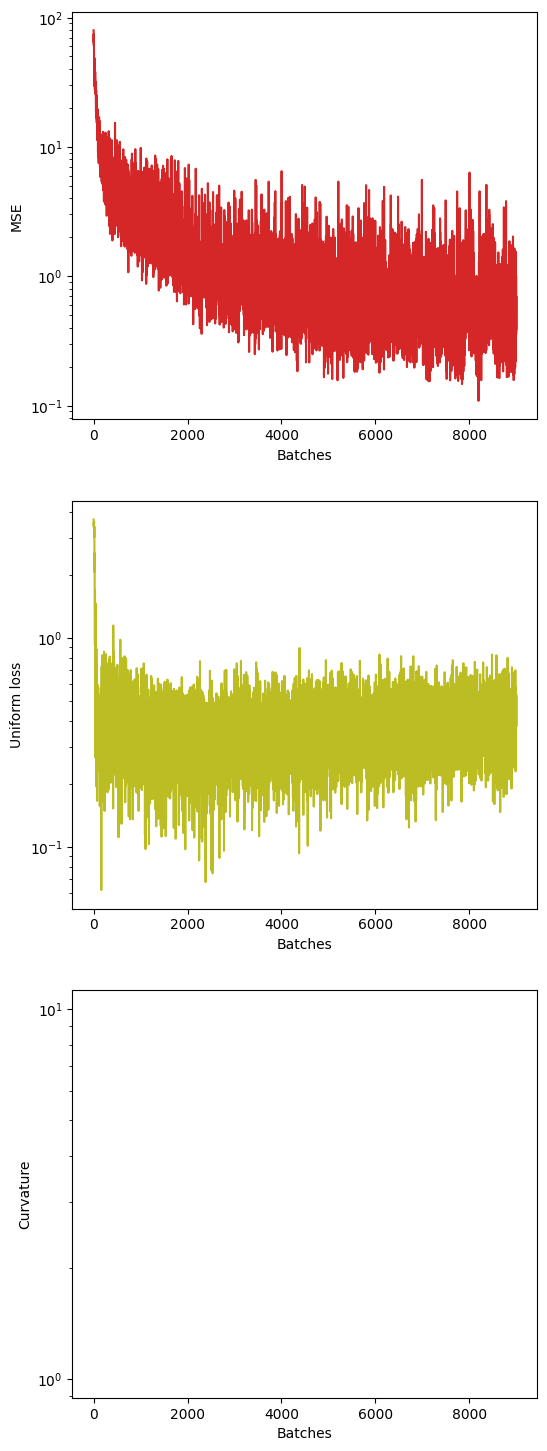

In [19]:
# loss ploting
fig,axes = ricci_regularization.PlottingTools.plot3losses(mse_loss_array,uniform_loss_array,curvatue_loss_array)
if violent_saving == True:
    fig.savefig(f"{Path_pictures}/losses_exp{experiment_number}.pdf",bbox_inches='tight',format="pdf")

## Torus latent space

In [20]:
#inspiration for torus_ae.encoder2lifting
"""
def circle2anglevectorized(zLatentTensor,d = d):
    cosphi = zLatentTensor[:, 0:d]
    sinphi = zLatentTensor[:, d:2*d]
    phi = torch.acos(cosphi)*torch.sgn(torch.asin(sinphi))
    return phi
"""


'\ndef circle2anglevectorized(zLatentTensor,d = d):\n    cosphi = zLatentTensor[:, 0:d]\n    sinphi = zLatentTensor[:, d:2*d]\n    phi = torch.acos(cosphi)*torch.sgn(torch.asin(sinphi))\n    return phi\n'

In [21]:
#zlist = []
colorlist = []
enc_list = []
input_dataset_list = []
recon_dataset_list = []
for (data, labels) in tqdm( train_loader, position=0 ):
#for (data, labels) in train_loader:
    input_dataset_list.append(data)
    recon_dataset_list.append(torus_ae(data)[0])
    #zlist.append(torus_ae(data)[1])
    enc_list.append(torus_ae.encoder2lifting(data.view(-1,D)))
    colorlist.append(labels) 

  0%|          | 0/450 [00:00<?, ?it/s]

In [22]:
input_dataset = torch.cat(input_dataset_list)
recon_dataset = torch.cat(recon_dataset_list)
encoded_points = torch.cat(enc_list)
encoded_points_no_grad = encoded_points.detach()/math.pi
color_array = torch.cat(colorlist).detach()

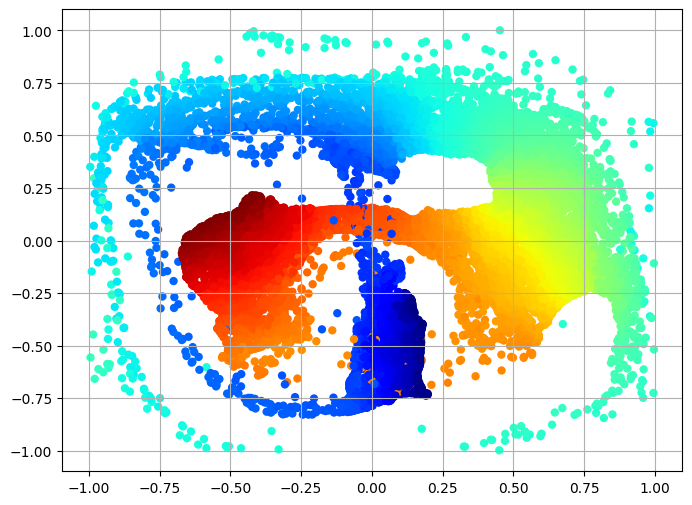

In [23]:
plt.figure(figsize=(8, 6))
if set_name == "Swissroll":
    my_cmap = "jet"
else:
    my_cmap = ricci_regularization.PlottingTools.discrete_cmap(k, 'jet')
plt.scatter(encoded_points_no_grad[:,0],encoded_points_no_grad[:,1], c=color_array, marker='o', edgecolor='none', cmap=my_cmap)

if set_name in ["Synthetic","MNIST"]:
    plt.colorbar(ticks=range(k))
plt.grid(True)
if violent_saving == True:
    plt.savefig(f"{Path_pictures}/latent_space_exp{experiment_number}.pdf",bbox_inches='tight',format="pdf")
plt.show()

In [24]:
import json
json_config = {
    "experiment_name": experiment_name,
    "experiment_number": experiment_number,
    "dataset":
    {
        "name": set_name,
        "parameters": set_parameters,
    },
    "architecture" :
    {
        "input_dim": D,
        "latent_dim": d
    },
    "optimization_parameters": 
    {
	    "learning_rate": lr,
        "momentum":momentum,
	    "batch_size": batch_size,
        "split_ratio": split_ratio,
	    "num_epochs": num_epochs,
	    "mse_w": mse_w,
	    "unif_w": unif_w,
	    "curv_w": curv_w,
        "compute_curvature": compute_curvature,
        "weight_decay": weight_decay,
        "random_seed": random_seed
    },
    "OOD_parameters": 
    {
        "OOD_regime": OOD_regime,
        "start_ood":start_ood,
        "T_ood":T_ood,
        "n_ood":n_ood,
        "sigma_ood":sigma_ood,
        "N_extr":N_extr,
        "r_ood": r_ood,
        "OOD_w":OOD_w
    },
    "training_results":
    {
        "R^2": test_R_squared.item(),
        "mse_loss": test_mse.item(),
        "unif_loss": test_unif.item(),
        "curv_loss": test_curv.item()
    },
    "Path_pictures": Path_pictures,
    "Path_weights": Path_weights,
    "Path_experiments": Path_experiments
}

# Save dictionary to JSON file
with open(f'{Path_experiments}/{experiment_name}exp{experiment_number}.json', 'w') as json_file:
    json.dump(json_config, json_file, indent=4)